# Get data from kaggle

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
# content/myDrive/Kaggle is the path where kaggle.json is
# present in Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

# change the working directory
%cd /content/gdrive/MyDrive/Kaggle

# check the present working directory using the pwd command
%pwd

/content/gdrive/MyDrive/Kaggle


'/content/gdrive/MyDrive/Kaggle'

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog

 94% 204M/218M [00:00<00:00, 258MB/s]
100% 218M/218M [00:00<00:00, 258MB/s]


In [4]:
!unzip cat-and-dog.zip && rm cat-and-dog.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  


# Packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
tf.__version__
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip


In [6]:
%pwd

'/content/gdrive/MyDrive/Kaggle'

## Create the dataset and split it into training and validation ests

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "training_set/training_set/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 8005 files belonging to 2 classes.
Using 1601 files for validation.


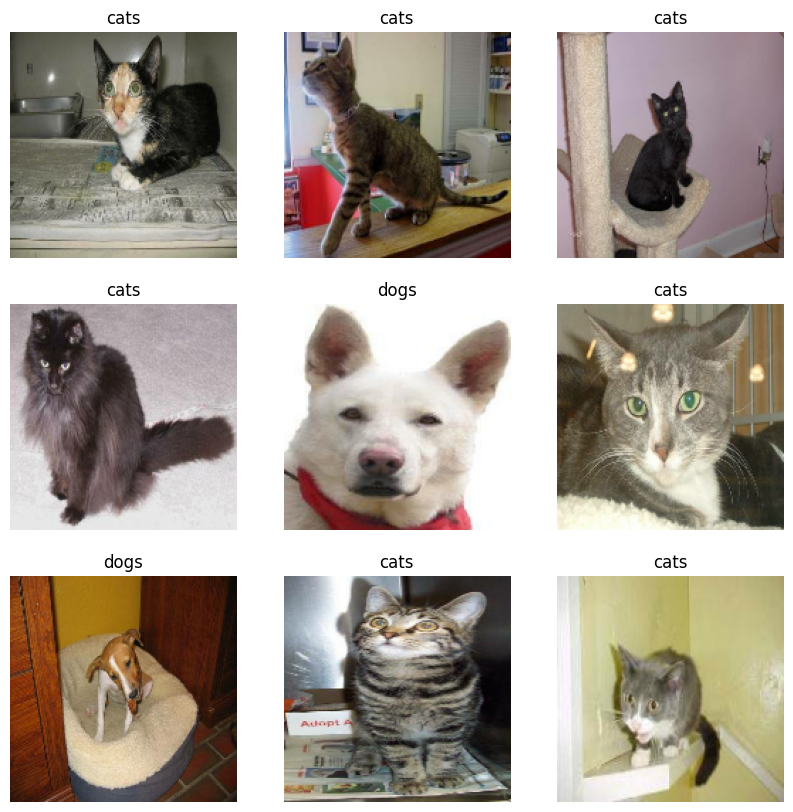

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

## Preprocess and augment training data

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation

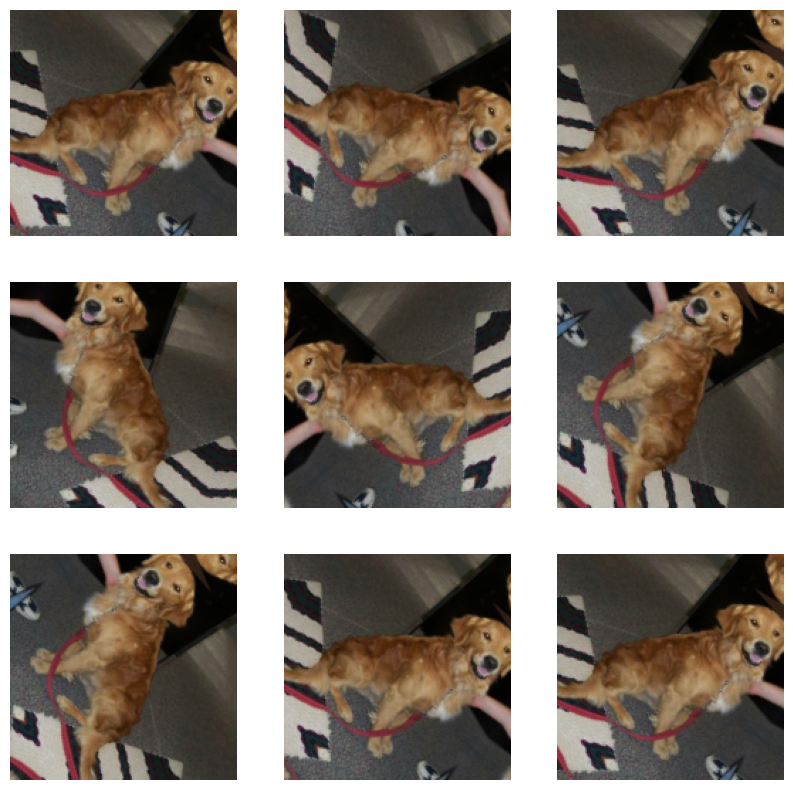

In [11]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 0s 0us/step


In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [17]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1], dtype=int32)>

In [18]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 0us/step


[[('n02093256', 'Staffordshire_bullterrier', 0.2500472),
  ('n02093428', 'American_Staffordshire_terrier', 0.18321048)],
 [('n02124075', 'Egyptian_cat', 0.80223507),
  ('n02123045', 'tabby', 0.07259225)],
 [('n02099601', 'golden_retriever', 0.070530415),
  ('n02086079', 'Pekinese', 0.06206002)],
 [('n02123045', 'tabby', 0.8019044), ('n02123159', 'tiger_cat', 0.15655498)],
 [('n02099601', 'golden_retriever', 0.80626726),
  ('n02104029', 'kuvasz', 0.10697744)],
 [('n02123394', 'Persian_cat', 0.16922228),
  ('n03223299', 'doormat', 0.05742311)],
 [('n02123597', 'Siamese_cat', 0.5597292),
  ('n02124075', 'Egyptian_cat', 0.18344423)],
 [('n02124075', 'Egyptian_cat', 0.5550398),
  ('n02123045', 'tabby', 0.22052906)],
 [('n02106662', 'German_shepherd', 0.9334156),
  ('n02105412', 'kelpie', 0.04486629)],
 [('n02104365', 'schipperke', 0.21494749), ('n02123045', 'tabby', 0.08495324)],
 [('n02106550', 'Rottweiler', 0.63124675),
  ('n02107312', 'miniature_pinscher', 0.10469528)],
 [('n02123159', '

## Layer Freezing with Functional API

In [19]:
def dog_cat_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                 include_top=False,
                                                 weights='imagenet')
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(0.2)(x)
  predict_layer = tf.keras.layers.Dense(1)
  outputs = predict_layer(x)

  model = tf.keras.Model(inputs, outputs)
  return model

In [20]:
model2 = dog_cat_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [22]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
201/201 [==============================] - 27s 92ms/step - loss: 0.2090 - accuracy: 0.9062 - val_loss: 0.0663 - val_accuracy: 0.9763
Epoch 2/5
201/201 [==============================] - 19s 90ms/step - loss: 0.1293 - accuracy: 0.9458 - val_loss: 0.0525 - val_accuracy: 0.9813
Epoch 3/5
201/201 [==============================] - 18s 86ms/step - loss: 0.1265 - accuracy: 0.9480 - val_loss: 0.0492 - val_accuracy: 0.9844
Epoch 4/5
201/201 [==============================] - 26s 126ms/step - loss: 0.1152 - accuracy: 0.9500 - val_loss: 0.0449 - val_accuracy: 0.9850
Epoch 5/5
201/201 [==============================] - 18s 86ms/step - loss: 0.1108 - accuracy: 0.9550 - val_loss: 0.0438 - val_accuracy: 0.9838


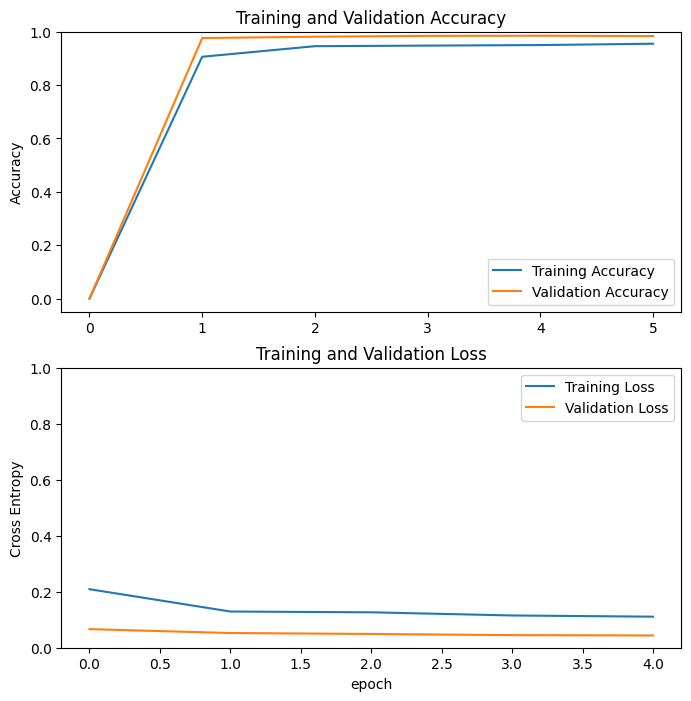

In [24]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
class_names

['cats', 'dogs']

## Fine tune cat_dog_model

In [26]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
               optimizer=optimizer,
               metrics=metrics)

Number of layers in the base model:  154


In [45]:
checkpoint_path = '/content/gdrive/MyDrive/Kaggle/training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
# create a callback that saves the model's weights
cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

In [46]:
print(checkpoint_dir)

/content/gdrive/MyDrive/Kaggle/training_1


In [47]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset,
                          callbacks=[cp_callbacks])

Epoch 5/10
200/201 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.9847
Epoch 5: saving model to /content/gdrive/MyDrive/Kaggle/training_1/cp.ckpt
201/201 [==============================] - 24s 116ms/step - loss: 0.0345 - accuracy: 0.9847 - val_loss: 0.0378 - val_accuracy: 0.9888
Epoch 6/10
200/201 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9875
Epoch 6: saving model to /content/gdrive/MyDrive/Kaggle/training_1/cp.ckpt
201/201 [==============================] - 19s 93ms/step - loss: 0.0295 - accuracy: 0.9875 - val_loss: 0.0308 - val_accuracy: 0.9856
Epoch 7/10
200/201 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9883
Epoch 7: saving model to /content/gdrive/MyDrive/Kaggle/training_1/cp.ckpt
201/201 [==============================] - 20s 99ms/step - loss: 0.0300 - accuracy: 0.9883 - val_loss: 0.0365 - val_accuracy: 0.9850
Epoch 8/10
200/201 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy

In [48]:
os.listdir(checkpoint_dir)

['cp.ckpt.data-00000-of-00001', 'cp.ckpt.index', 'checkpoint']

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

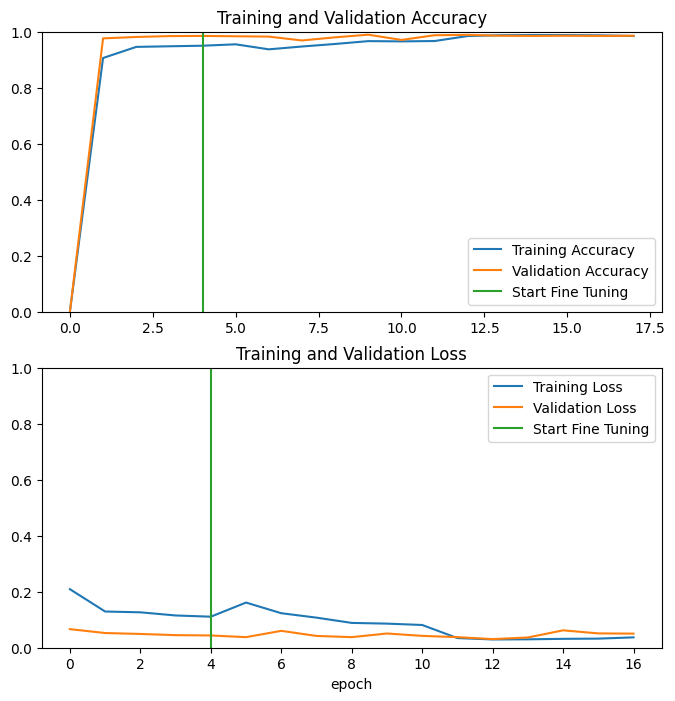

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()